# PHATE -> Leiden Clustering -> Trajectory Inference

This notebook describes how PHATE was used in combination with Leiden Clustering to establish soft labels for training CNN to predict cell states. 

In [39]:
import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phate
import scanpy as sc

from scipy.stats import spearmanr
from sklearn.decomposition import PCA
from sklearn.manifold import trustworthiness
from sklearn.metrics import pairwise_distances

## PCA

We need to start with PCA reduction so that we can feed this back into PHATE, kNN, and Leiden clustering. 

In [30]:
data_csv = pd.read_csv("/data/processed/tabular/cells_znorm.csv", index_col=0)

pca = PCA(n_components=50)
data_pca = pca.fit_transform(data_csv)

pca_df = pd.DataFrame(data=data_pca, columns=[f'PC {i}' for i in range(1,pca.n_components_ + 1)]).set_index(data_csv.index)

loadings = pd.DataFrame(pca.components_.T, columns=pca_df.columns, index=data_csv.columns)

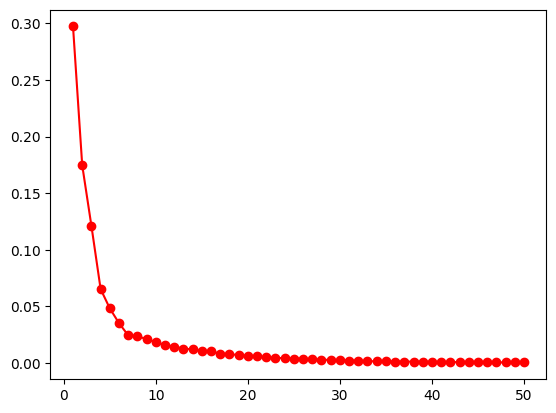

In [31]:
pc_values = np.arange(pca.n_components_) + 1
plt.plot(pc_values, pca.explained_variance_ratio_, 'ro-')

In [32]:
loadings.sort_values(by=[f'{i}' for i in loadings.columns], ascending=False)

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,...,PC 41,PC 42,PC 43,PC 44,PC 45,PC 46,PC 47,PC 48,PC 49,PC 50
R7_GATA4_total_nuc_protein,0.157875,0.143140,0.024417,0.036557,0.018905,-0.010367,-0.025023,0.008545,-0.034486,-0.015055,...,-0.131784,0.053679,0.002486,0.050850,0.067940,0.059394,0.065868,-0.055279,0.028593,0.043336
R3_PLAUR_total_nuc_protein,0.156725,0.135790,0.029057,0.059963,0.048020,0.001270,0.064691,0.011938,-0.022009,-0.041646,...,0.126452,-0.079896,-0.151884,0.052955,0.096228,-0.031415,-0.234432,0.085665,0.009721,-0.074549
R7_pp38_nuc_mean,0.155488,-0.081543,-0.036435,0.059913,-0.082472,-0.007690,-0.192366,0.023918,-0.059386,0.121732,...,0.030444,0.069619,-0.043162,-0.119555,0.132508,0.087353,-0.014865,-0.032539,-0.013972,-0.095972
R6_p65_total_nuc_protein,0.155426,0.142293,0.014392,0.069179,0.031913,-0.032607,0.061079,0.010156,0.008210,-0.032206,...,0.023634,0.003238,-0.197765,0.053645,0.069042,-0.191659,-0.264331,0.032899,0.011980,-0.007049
R5_p38_total_nuc_protein,0.155325,0.151962,0.038103,-0.013719,0.007512,-0.028322,-0.007179,0.000473,-0.015403,-0.025143,...,-0.223352,0.014698,0.037513,-0.014668,0.013151,0.015960,0.066696,0.018726,-0.055078,-0.028681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R1_p21_ratio,-0.028070,-0.071702,0.085052,0.252917,0.129770,0.068508,0.173178,-0.022426,0.131224,-0.147847,...,-0.046282,-0.072672,-0.003184,-0.253875,0.110516,-0.061375,-0.065655,-0.041691,-0.174412,0.036466
pp65_p65_nuc_mean_ratio,-0.028716,0.029306,0.067868,-0.185493,-0.030905,0.458251,0.013544,-0.035009,-0.114956,0.045794,...,-0.027601,-0.060731,0.074159,0.003973,0.119567,-0.151006,0.105190,0.061383,-0.003676,0.042298
pp65_p65_nuc_total_ratio,-0.028716,0.029306,0.067868,-0.185493,-0.030905,0.458251,0.013544,-0.035009,-0.114956,0.045794,...,-0.027601,-0.060731,0.074159,0.003973,0.119567,-0.151006,0.105190,0.061383,-0.003676,0.042298
pp38_p38_ring_mean_ratio,-0.052198,0.045286,0.042773,0.189951,0.103686,0.192824,-0.103142,0.029473,0.004760,0.093980,...,-0.055578,-0.201932,0.003195,0.017909,0.005223,-0.121741,0.036017,0.112216,0.052567,-0.062099


## kNN Graph

Now we build a kNN graph of neighbors which PHATE and Leiden will use under the hood.

In [34]:
adata = sc.AnnData(pca_df)
adata

sc.pp.neighbors(adata, n_neighbors=30, use_rep='X')

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## PHATE

Here, we will perform PHATE with hyperparameter tuning to genereate preliminary trajectories. 

In [41]:
results = []

for k in [5, 10, 15, 20, 25, 30, 40, 45, 50]:
    for t in ['auto', 3, 8]:
        phate = phate.PHATE(knn=k, t=t, n_components=3)
        embeddings = phate.fit_transform(pca_df)
        trust = trustworthiness(pca_df, embeddings, n_neighbors=30)
        rho, _ = spearmanr(pairwise_distances(pca_df).ravel(),
                           pairwise_distances(embeddings).ravel())
        
        results.append({'k': k, 't': t, 'trust': trust, 'rho': rho})
        
scores = pd.DataFrame(results)
print(scores)

Calculating PHATE...
  Running PHATE on 42784 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 60.41 seconds.
    Calculating affinities...
    Calculated affinities in 0.27 seconds.
  Calculated graph and diffusion operator in 60.72 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 4.00 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.50 seconds.
  Calculated landmark operator in 8.37 seconds.
  Calculating optimal t...
    Automatically selected t = 27
  Calculated optimal t in 1.48 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.63 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 14.80 seconds.
Calculated PHATE in 86.01 seconds.


: 